# Entwicklungen in der Landwirtschaft 2000–2019

### Imports

In [1]:
import requests
import pandas as pd
from pyaxis import pyaxis
import numpy as np
import re
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point, LineString
from geopandas import GeoDataFrame
import matplotlib.patches as mpatches
import matplotlib
%matplotlib inline

## DF's erzeugen
### DF Landwirtschaft (df)

In [2]:
# Landwirtschaftsdaten einlesen und DF erzeugen
url_lw = r'https://www.bfs.admin.ch/bfsstatic/dam/assets/12727132/master'
px = pyaxis.parse(uri = url_lw , encoding = 'iso-8859-15')
df = px['DATA']
meta_df = px['METADATA']
df.head(2)

,Beobachtungseinheit,Kanton (-) / Bezirk (>>) / Gemeinde (......),Betriebssystem,Jahr,DATA
0,Betriebe,Schweiz,Betriebssystem - Total,2019,50038
1,Betriebe,Schweiz,Betriebssystem - Total,2018,50852


### DF Gemeinden (gemeinden)

In [3]:
# Gemeindestand einlesen und DF für Zuweisung der Kantone und Bezirke erzeugen
gemeinden_raw = pd.read_excel("Gemeindestand.xlsx")
gemeinden_raw = gemeinden_raw.rename(columns={'Bezirks-nummer': 'Bezirksnummer', 'BFS Gde-nummer': 'Gemeindenummer'})
gemeinden = gemeinden_raw.reindex(columns=['Gemeindenummer', 'Gemeindename', 'Bezirksname', 'Bezirksnummer', 'Kanton'])
gemeinden.head(2)

,Gemeindenummer,Gemeindename,Bezirksname,Bezirksnummer,Kanton
0,1,Aeugst am Albis,Affoltern,101,ZH
1,2,Affoltern am Albis,Affoltern,101,ZH


### Geometrie Kantone einlesen (gdf_kantone)

In [4]:
# Geometrie Kantone einlesen
gdf_kantone = gpd.read_file('Kantonskarte/g1k17.shp')

# Kantonsnamen vereinfachen
gdf_kantone['KTNAME'] = gdf_kantone['KTNAME'].replace(['Appenzell Ausserrhoden'],'Appenzell A.Rh.')
gdf_kantone['KTNAME'] = gdf_kantone['KTNAME'].replace(['Appenzell Innerrhoden'],'Appenzell I.Rh.')
gdf_kantone['KTNAME'] = gdf_kantone['KTNAME'].replace(['Valais / Wallis'],'Wallis')
gdf_kantone['KTNAME'] = gdf_kantone['KTNAME'].replace(['Bern / Berne'],'Bern')
gdf_kantone['KTNAME'] = gdf_kantone['KTNAME'].replace(['Fribourg / Freiburg'],'Freiburg')
gdf_kantone['KTNAME'] = gdf_kantone['KTNAME'].replace(['Graubünden / Grigioni / Grischun'],'Graubünden')
gdf_kantone['KTNAME'] = gdf_kantone['KTNAME'].replace(['Neuchâtel'],'Neuenburg')
gdf_kantone['KTNAME'] = gdf_kantone['KTNAME'].replace(['Vaud'],'Waadt')
gdf_kantone['KTNAME'] = gdf_kantone['KTNAME'].replace(['Ticino'],'Tessin')
gdf_kantone['KTNAME'] = gdf_kantone['KTNAME'].replace(['Genève'],'Genf')
gdf_kantone['KTNAME'] = gdf_kantone['KTNAME'].replace(['Basel-Landschaft'],'Basel-Land')

### Geometrie Gemeinden SH einlesen (gdf_sh)

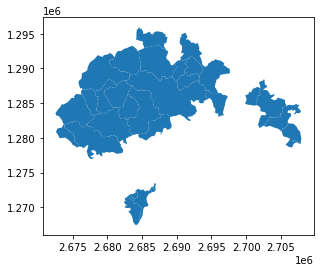

In [5]:
# Geometrie Gemeinden CH einlesen
gdf_gemeinden = gpd.read_file('SHAPEFILE_LV95/swissTLMRegio_HOHEITSGEBIET_LV95.shp')
gdf_gemeinden['BFS_NUMMER'] = gdf_gemeinden['BFS_NUMMER'].astype(int)

# Reduzieren auf Gemeinden SH
gdf_sh = gdf_gemeinden.loc[gdf_gemeinden['KANTONSNUM'] == 'CH14000000', ['BFS_NUMMER','NAME', 'KANTONSNUM', 'GEM_FLAECH', 'SEE_FLAECH', 'EINWOHNERZ', 'geometry']]
gdf_sh.plot()

## DF Landwirtschaft sichten

In [6]:
# Schauen was im DF Landwirtschaft ist
df.head(2)

,Beobachtungseinheit,Kanton (-) / Bezirk (>>) / Gemeinde (......),Betriebssystem,Jahr,DATA
0,Betriebe,Schweiz,Betriebssystem - Total,2019,50038
1,Betriebe,Schweiz,Betriebssystem - Total,2018,50852


In [7]:
# Schauen was in "Beobachtungseinheiten" ist
df['Beobachtungseinheit']

0                             Betriebe
1                             Betriebe
2                             Betriebe
3                             Betriebe
4                             Betriebe
                      ...             
7704251    Betriebe mit übrigen Tieren
7704252    Betriebe mit übrigen Tieren
7704253    Betriebe mit übrigen Tieren
7704254    Betriebe mit übrigen Tieren
7704255    Betriebe mit übrigen Tieren
Name: Beobachtungseinheit, Length: 7704256, dtype: object

In [8]:
# Schauen was in "Kanton (-) / Bezirk (>>) / Gemeinde (......)" ist
df['Kanton (-) / Bezirk (>>) / Gemeinde (......)']

0                        Schweiz
1                        Schweiz
2                        Schweiz
3                        Schweiz
4                        Schweiz
                   ...          
7704251    ......6810 La Baroche
7704252    ......6810 La Baroche
7704253    ......6810 La Baroche
7704254    ......6810 La Baroche
7704255    ......6810 La Baroche
Name: Kanton (-) / Bezirk (>>) / Gemeinde (......), Length: 7704256, dtype: object

## DF Landwirtschaft in Gemeinden, Bezirke, Kantone und Schweiz splitten 
### Regex' erstellen

In [9]:
# Regex-Schlüssel erstellen
regex_ch = r"Schweiz"
regex_k = r"^- .+$"
regex_b = r"^>> .+$"
regex_g = r"^\.{6}\d{4} .+$"

# Regex-Schlüssel testen
re.search(regex_k, "......6810 La Baroche")

### Filtern mit Regex

In [10]:
# Regex anwenden
df_ch_raw = df[df['Kanton (-) / Bezirk (>>) / Gemeinde (......)'].str.contains(regex_ch)].copy()
df_k_raw = df[df['Kanton (-) / Bezirk (>>) / Gemeinde (......)'].str.contains(regex_k)].copy()
df_b_raw = df[df['Kanton (-) / Bezirk (>>) / Gemeinde (......)'].str.contains(regex_b)].copy()
df_g_raw = df[df['Kanton (-) / Bezirk (>>) / Gemeinde (......)'].str.contains(regex_g)].copy()

df_g_raw.head(2)

,Beobachtungseinheit,Kanton (-) / Bezirk (>>) / Gemeinde (......),Betriebssystem,Jahr,DATA
336,Betriebe,......0001 Aeugst am Albis,Betriebssystem - Total,2019,14
337,Betriebe,......0001 Aeugst am Albis,Betriebssystem - Total,2018,14


## Bereinigen DF Gemeinden
### Spalten optimieren

In [11]:
# Spalten umbenennen
df_g_raw = df_g_raw.rename(columns={'Kanton (-) / Bezirk (>>) / Gemeinde (......)': 'Gemeinde', 'DATA': 'Anzahl'})

df_g_raw.head(2)

,Beobachtungseinheit,Gemeinde,Betriebssystem,Jahr,Anzahl
336,Betriebe,......0001 Aeugst am Albis,Betriebssystem - Total,2019,14
337,Betriebe,......0001 Aeugst am Albis,Betriebssystem - Total,2018,14


### Gemeindenummer und Gemeindename splitten

In [12]:
# Gemeindenummer in neue Spalte
df_g_raw['Nummer'] = df_g_raw['Gemeinde'].str.extract(r"^\.{6}(\d{4}) .+$")

# Gemeindename in neue Spalte
df_g_raw['Gemeinde'] = df_g_raw['Gemeinde'].str.extract(r"^\.{6}\d{4} (.+)$")

# Nur Benötigtes mitnehmen
df_g = df_g_raw.reindex(columns=['Gemeinde', 'Jahr', 'Beobachtungseinheit', 'Betriebssystem', 'Anzahl', 'Nummer'])

df_g.head(2)

,Gemeinde,Jahr,Beobachtungseinheit,Betriebssystem,Anzahl,Nummer
336,Aeugst am Albis,2019,Betriebe,Betriebssystem - Total,14,0001
337,Aeugst am Albis,2018,Betriebe,Betriebssystem - Total,14,0001


### Gemeinden mit Bezirken/Kantonen mergen 

In [13]:
# Gemeindenummer in Integer umwandeln
df_g["Nummer"] = df_g["Nummer"].astype(int)
gemeinden["Gemeindenummer"].dtype

dtype('int64')

In [14]:
# DF Gemeinden mit Gemeinde-Daten mergen
df_g = df_g.merge(gemeinden, left_on='Nummer', right_on='Gemeindenummer')

# Nur Benötigtes mitnehmen
del df_g['Gemeindenummer']
del df_g['Gemeindename']
del df_g['Bezirksnummer']
df_g = df_g.rename(columns={'Nummer': 'Gemeindenummer', 'Beobachtungseinheit': 'Einheit', 'Betriebssystem': 'System'})

df_g.head(2)

,Gemeinde,Jahr,Einheit,System,Anzahl,Gemeindenummer,Bezirksname,Kanton
0,Aeugst am Albis,2019,Betriebe,Betriebssystem - Total,14,1,Affoltern,ZH
1,Aeugst am Albis,2018,Betriebe,Betriebssystem - Total,14,1,Affoltern,ZH


### Schaffhauser Gemeinden herausziehen und mit Geometrie mergen

In [15]:
# Schaffhauser Gemeinden filtern
df_sh = df_g.loc[df_g['Kanton'] == 'SH', ['Gemeinde', 'Gemeindenummer', 'Bezirksname', 'Jahr', 'Einheit', 'System', 'Anzahl']]

# Schaffhauser Gemeinden mit Geometrie mergen
gdf_sh = df_sh.merge(gdf_sh, left_on='Gemeindenummer', right_on='BFS_NUMMER')

gdf_sh.head(2)

,Gemeinde,Gemeindenummer,Bezirksname,Jahr,Einheit,System,Anzahl,BFS_NUMMER,NAME,KANTONSNUM,GEM_FLAECH,SEE_FLAECH,EINWOHNERZ,geometry
0,Gächlingen,2901,Oberklettgau,2019,Betriebe,Betriebssystem - Total,22,2901,Gächlingen,CH14000000,713.0,-29998.0,876,"POLYGON Z ((2680808.000 1284383.000 -0.000, 26..."
1,Gächlingen,2901,Oberklettgau,2018,Betriebe,Betriebssystem - Total,21,2901,Gächlingen,CH14000000,713.0,-29998.0,876,"POLYGON Z ((2680808.000 1284383.000 -0.000, 26..."


## Bereinigen DF Kantone

In [16]:
# Spaltenbezeichnungen optimieren
df_k_raw = df_k_raw.rename(columns={'Kanton (-) / Bezirk (>>) / Gemeinde (......)': 'Kanton', 'DATA': 'Anzahl', 'Betriebssystem': 'System', 'Beobachtungseinheit': 'Einheit'})

df_k_raw

,Einheit,Kanton,System,Jahr,Anzahl
112,Betriebe,- Zürich,Betriebssystem - Total,2019,3258
113,Betriebe,- Zürich,Betriebssystem - Total,2018,3346
114,Betriebe,- Zürich,Betriebssystem - Total,2017,3432
115,Betriebe,- Zürich,Betriebssystem - Total,2016,3493
116,Betriebe,- Zürich,Betriebssystem - Total,2015,3599
...,...,...,...,...,...
7697979,Betriebe mit übrigen Tieren,- Jura,Unbestimmt,1996,0
7697980,Betriebe mit übrigen Tieren,- Jura,Unbestimmt,1990,0
7697981,Betriebe mit übrigen Tieren,- Jura,Unbestimmt,1985,661
7697982,Betriebe mit übrigen Tieren,- Jura,Unbestimmt,1980,793


In [17]:
# Kantonsnamen bereinigen
df_k_raw['Kanton'] = df_k_raw['Kanton'].str.extract(r"^- (.+)$")

df_k_raw

,Einheit,Kanton,System,Jahr,Anzahl
112,Betriebe,Zürich,Betriebssystem - Total,2019,3258
113,Betriebe,Zürich,Betriebssystem - Total,2018,3346
114,Betriebe,Zürich,Betriebssystem - Total,2017,3432
115,Betriebe,Zürich,Betriebssystem - Total,2016,3493
116,Betriebe,Zürich,Betriebssystem - Total,2015,3599
...,...,...,...,...,...
7697979,Betriebe mit übrigen Tieren,Jura,Unbestimmt,1996,0
7697980,Betriebe mit übrigen Tieren,Jura,Unbestimmt,1990,0
7697981,Betriebe mit übrigen Tieren,Jura,Unbestimmt,1985,661
7697982,Betriebe mit übrigen Tieren,Jura,Unbestimmt,1980,793


In [18]:
# Spalten neu anordnen
df_k = df_k_raw.reindex(columns=['Kanton', 'Jahr', 'Einheit', 'System', 'Anzahl'])

# Kantonsnamen optimieren
df_k['Kanton'] = df_k['Kanton'].replace(['Appenzell Ausserrhoden'],'Appenzell A.Rh.')
df_k['Kanton'] = df_k['Kanton'].replace(['Appenzell Innerrhoden'],'Appenzell I.Rh.')
df_k['Kanton'] = df_k['Kanton'].replace(['Valais / Wallis'],'Wallis')
df_k['Kanton'] = df_k['Kanton'].replace(['Bern / Berne'],'Bern')
df_k['Kanton'] = df_k['Kanton'].replace(['Fribourg / Freiburg'],'Freiburg')
df_k['Kanton'] = df_k['Kanton'].replace(['Graubünden / Grigioni / Grischun'],'Graubünden')
df_k['Kanton'] = df_k['Kanton'].replace(['Neuchâtel'],'Neuenburg')
df_k['Kanton'] = df_k['Kanton'].replace(['Vaud'],'Waadt')
df_k['Kanton'] = df_k['Kanton'].replace(['Ticino'],'Tessin')
df_k['Kanton'] = df_k['Kanton'].replace(['Genève'],'Genf')
df_k['Kanton'] = df_k['Kanton'].replace(['Basel-Landschaft'],'Basel-Land')

df_k.head(2)

,Kanton,Jahr,Einheit,System,Anzahl
112,Zürich,2019,Betriebe,Betriebssystem - Total,3258
113,Zürich,2018,Betriebe,Betriebssystem - Total,3346


## Bereinigen DF Schweiz

In [19]:
# Spaltenbezeichnungen optimieren
df_ch_raw = df_ch_raw.rename(columns={'Kanton (-) / Bezirk (>>) / Gemeinde (......)': 'Land', 'DATA': 'Anzahl', 'Betriebssystem': 'System', 'Beobachtungseinheit': 'Einheit'})

# Spalten neu anordnen
df_ch = df_ch_raw.reindex(columns=['Jahr', 'Einheit', 'System', 'Anzahl'])

df_ch.head(2)

,Jahr,Einheit,System,Anzahl
0,2019,Betriebe,Betriebssystem - Total,50038
1,2018,Betriebe,Betriebssystem - Total,50852


## Datenauswertung

### Datensichtung

In [20]:
# Wie sieht das DF Schweiz aus?
df_ch.head(2)

,Jahr,Einheit,System,Anzahl
0,2019,Betriebe,Betriebssystem - Total,50038
1,2018,Betriebe,Betriebssystem - Total,50852


In [21]:
# Wie sieht das DF Kantone aus?
df_k.head(2)

,Kanton,Jahr,Einheit,System,Anzahl
112,Zürich,2019,Betriebe,Betriebssystem - Total,3258
113,Zürich,2018,Betriebe,Betriebssystem - Total,3346


In [22]:
# Wie sieht das DF Gemeinden aus?
df_g.head(2)

,Gemeinde,Jahr,Einheit,System,Anzahl,Gemeindenummer,Bezirksname,Kanton
0,Aeugst am Albis,2019,Betriebe,Betriebssystem - Total,14,1,Affoltern,ZH
1,Aeugst am Albis,2018,Betriebe,Betriebssystem - Total,14,1,Affoltern,ZH


In [23]:
# Wie sieht das DF Gemeinden SH aus?
df_sh.head(2)

,Gemeinde,Gemeindenummer,Bezirksname,Jahr,Einheit,System,Anzahl
3196032,Gächlingen,2901,Oberklettgau,2019,Betriebe,Betriebssystem - Total,22
3196033,Gächlingen,2901,Oberklettgau,2018,Betriebe,Betriebssystem - Total,21


In [24]:
# Wie sieht das GDF Gemeinden SH aus?
gdf_sh.head(2)

,Gemeinde,Gemeindenummer,Bezirksname,Jahr,Einheit,System,Anzahl,BFS_NUMMER,NAME,KANTONSNUM,GEM_FLAECH,SEE_FLAECH,EINWOHNERZ,geometry
0,Gächlingen,2901,Oberklettgau,2019,Betriebe,Betriebssystem - Total,22,2901,Gächlingen,CH14000000,713.0,-29998.0,876,"POLYGON Z ((2680808.000 1284383.000 -0.000, 26..."
1,Gächlingen,2901,Oberklettgau,2018,Betriebe,Betriebssystem - Total,21,2901,Gächlingen,CH14000000,713.0,-29998.0,876,"POLYGON Z ((2680808.000 1284383.000 -0.000, 26..."


In [25]:
# Was ist in 'Einheit'?
df_ch['Einheit'].value_counts()

Beschäftigte Männer                                  112
Tiere - Schafe                                       112
LN - Übrige LN (in ha)                               112
Betriebe mit Schafen                                 112
Beschäftigte Ausländer                               112
Beschäftigte Teilzeit 2 (unter 50%)                  112
Tiere - Ziege                                        112
Beschäftigte Vollzeit (ab 75%)                       112
Beschäftigte Frauen                                  112
Beschäftigte Schweizer                               112
Betriebe mit Schweinen                               112
Betriebe mit übrigen Tieren                          112
LN - Landwirtschaftliche Nutzfläche Total (in ha)    112
LN - Offene Ackerfläche (in ha)                      112
Betriebe mit Rindern                                 112
Tiere - Pferdegattung                                112
Betriebe mit Geflügel                                112
Beschäftigte Total             

In [26]:
# Was ist in 'System'?
df_ch['System'].value_counts()

Unbestimmt                 812
Konventionelle Betriebe    812
Biologische Betriebe       812
Betriebssystem - Total     812
Name: System, dtype: int64

## Grafiken
### Schweiz
#### Entwicklung Anzahl LW-Betriebe in der Schweiz ab 2000 (df_ch_total)

INFO:numexpr.utils:NumExpr defaulting to 6 threads.


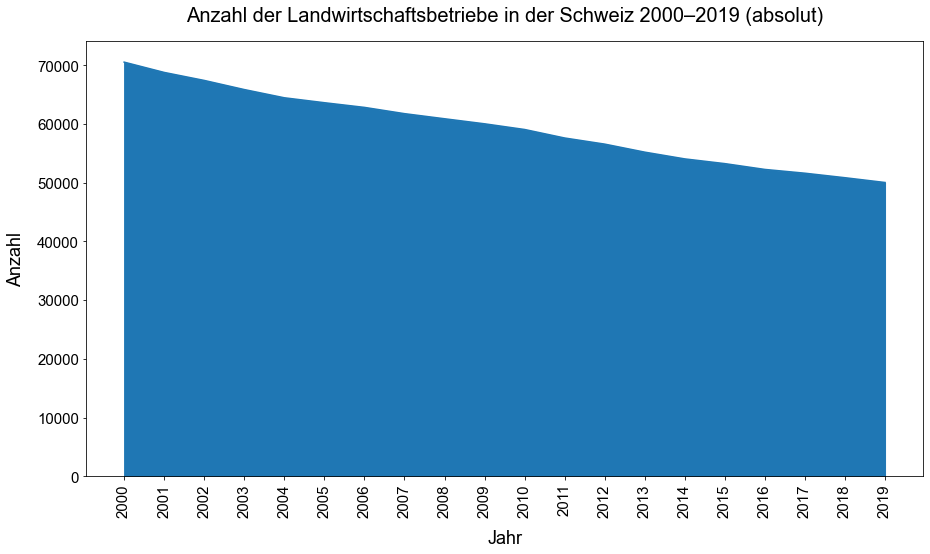

In [27]:
# Betriebe filtern

df_ch_betriebe1 = df_ch.loc[df_ch['Einheit'] == 'Betriebe', ['Jahr', 'System', 'Anzahl']]

# 'Betriebssystem - Total' filtern
df_ch_betriebe = df_ch_betriebe1.loc[df_ch_betriebe1['System'] == 'Betriebssystem - Total', ['Jahr', 'Anzahl']]

# Integer auf Jahr und Anzahl anwenden
df_ch_betriebe["Jahr"] = df_ch_betriebe["Jahr"].astype(int)
df_ch_betriebe["Anzahl"] = df_ch_betriebe["Anzahl"].astype(int)

# Jahre ab und mit 2000 filtern
df_ch_betriebe = df_ch_betriebe[df_ch_betriebe.Jahr >= 2000]

# Index neu setzen
df_ch_betriebe.set_index('Jahr', inplace=True)
df_ch_betriebe = df_ch_betriebe.sort_index(ascending=True)

# Plot erstellen
df_ch_betriebe.plot.area(use_index=True, figsize=(15,8), legend=None)
plt.yticks(np.arange(0, 75000, step=10000))
plt.xticks(np.arange(2000, 2020, step=1))
plt.style.use('seaborn-whitegrid')
plt.title('Anzahl der Landwirtschaftsbetriebe in der Schweiz 2000–2019 (absolut)', fontsize=20, pad=20)
plt.xlabel('Jahr', fontsize=18, labelpad=12)
plt.ylabel('Anzahl', fontsize=18, labelpad=12)
plt.xticks(fontsize=15, rotation=90)
plt.yticks(fontsize=15)
plt.gca().yaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%d')) 
plt.show()

#### Entwicklung Anzahl LW-Betriebe in der Schweiz ab 2000 nach Betriebssystem (df_ch_art)

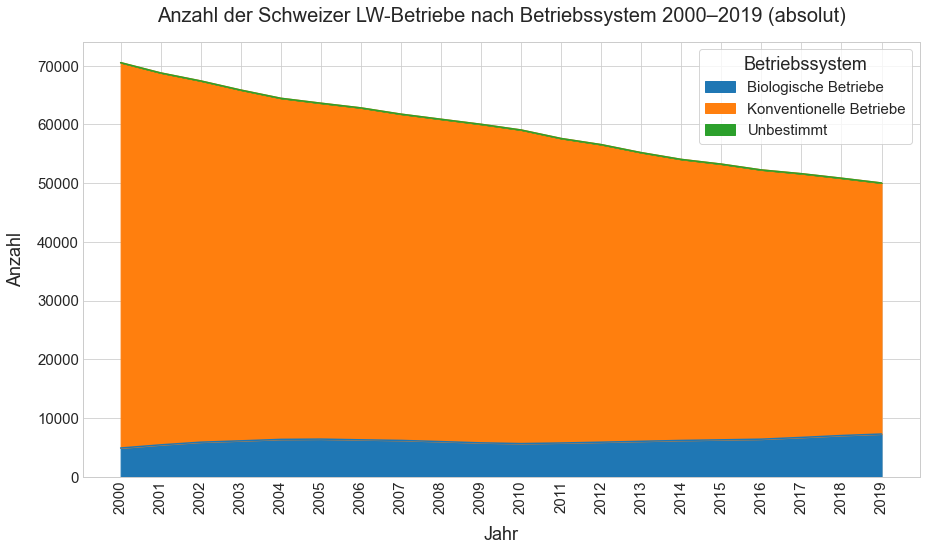

In [28]:
# Betriebe filtern
df_ch_art1 = df_ch.loc[df_ch['Einheit'] == 'Betriebe', ['Jahr', 'System', 'Anzahl']]

# Betriebssystem - Total filtern
df_ch_art1 = df_ch_art1.loc[df_ch_art1['System'] != 'Betriebssystem - Total', ['Jahr', 'System', 'Anzahl']]

# Integer auf Jahr anwenden
df_ch_art1["Jahr"] = df_ch_art1["Jahr"].astype(int)

# Jahre ab und mit 2000 filtern
df_ch_art1 = df_ch_art1[df_ch_art1.Jahr >= 2000]

# Integer auf Anzahl anwenden
df_ch_art1["Anzahl"] = df_ch_art1["Anzahl"].astype(int)

# Index neu sortieren
df_ch_art = df_ch_art1.sort_index(ascending=True)

# In Pivot umwandeln
df_ch_art_pivot = df_ch_art.pivot(index='Jahr', columns='System', values='Anzahl')

# Plot erstellen
df_ch_art_pivot.plot.area(use_index=True, figsize=(15,8))
plt.yticks(np.arange(0, 75000, step=10000))
plt.xticks(np.arange(2000, 2020, step=1))
plt.style.use('seaborn-whitegrid')
plt.title('Anzahl der Schweizer LW-Betriebe nach Betriebssystem 2000–2019 (absolut)', fontsize=20, pad=20)
plt.xlabel('Jahr', fontsize=18, labelpad=12)
plt.ylabel('Anzahl', fontsize=18, labelpad=12)
plt.xticks(fontsize=15, rotation=90)
plt.yticks(fontsize=15)
plt.legend(frameon=True, fontsize=15, title='Betriebssystem',title_fontsize=18)
plt.gca().yaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%d')) 
plt.show()

#### Entwicklung Anzahl Beschäftigte ab 2000 (df_ch_worker)

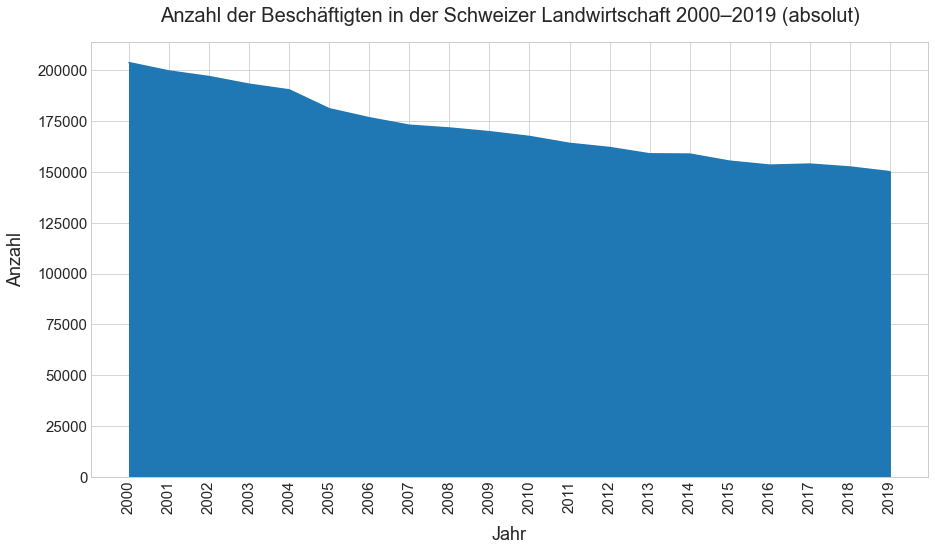

In [29]:
# Beschäftigte filtern
df_ch_worker1 = df_ch.loc[df_ch['Einheit'] == 'Beschäftigte Total', ['Jahr', 'System', 'Anzahl']]

# Betriebe filtern
df_ch_worker = df_ch_worker1.loc[df_ch_worker1['System'] == 'Betriebssystem - Total', ['Jahr', 'Anzahl']]

# Integer auf 'Jahr' anwenden
df_ch_worker["Jahr"] = df_ch_worker["Jahr"].astype(int)

# Jahre ab und mit 2000 filtern
df_ch_worker = df_ch_worker[df_ch_worker.Jahr >= 2000]

# Integer auf 'Anzahl' anwenden
df_ch_worker["Anzahl"] = df_ch_worker["Anzahl"].astype(int)

# 'Jahr' als Index setzen
df_ch_worker.set_index('Jahr', inplace=True)

# Index neu sortieren
df_ch_worker = df_ch_worker.sort_index(ascending=True)

# Plot erstellen
df_ch_worker.plot.area(use_index=True, figsize=(15,8), legend=None)
plt.yticks(np.arange(0, 201000, step=25000))
plt.xticks(np.arange(2000, 2020, step=1))
plt.style.use('seaborn-whitegrid')
plt.title('Anzahl der Beschäftigten in der Schweizer Landwirtschaft 2000–2019 (absolut)', fontsize=20, pad=20)
plt.xlabel('Jahr', fontsize=18, labelpad=12)
plt.ylabel('Anzahl', fontsize=18, labelpad=12)
plt.xticks(fontsize=15, rotation=90)
plt.yticks(fontsize=15)
plt.gca().yaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%d')) 
plt.show()

#### Entwicklung Anzahl Beschäftigte in der Schweizer Landwirtschaft nach Geschlecht ab 2000 (df_ch_gend)

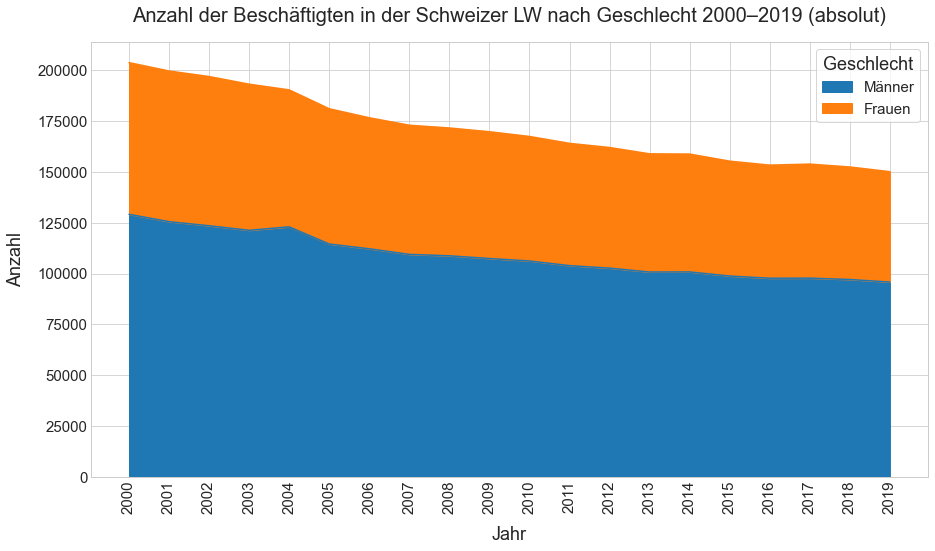

In [30]:
# 'Beschäftigte Männer' filtern
df_ch_man1 = df_ch.loc[df_ch['Einheit'] == 'Beschäftigte Männer', ['Jahr', 'System', 'Anzahl']]

# Betriebe filtern
df_ch_man = df_ch_man1.loc[df_ch_man1['System'] == 'Betriebssystem - Total', ['Jahr', 'Anzahl']]

# Spaltenüberschrift 'Anzahl' in 'Anzahl Männer' umbenennen
df_ch_man = df_ch_man.rename(columns={'Anzahl': 'Männer'})

# Integer auf Jahr anwenden
df_ch_man["Jahr"] = df_ch_man["Jahr"].astype(int)

# Jahre ab und mit 2000 filtern
df_ch_man = df_ch_man[df_ch_man.Jahr >= 2000]

# Integer auf 'Anzahl Männer' anwenden
df_ch_man["Männer"] = df_ch_man["Männer"].astype(int)

# String auf 'Jahr' anwenden
df_ch_man["Jahr"] = df_ch_man["Jahr"].astype(str)

# 'Jahr' als Index setzen
df_ch_man.set_index('Jahr', inplace=True)

# Index neu sortieren
df_ch_man = df_ch_man.sort_index(ascending=True)



# 'Beschäftigte Frauen' filtern
df_ch_fem1 = df_ch.loc[df_ch['Einheit'] == 'Beschäftigte Frauen', ['Jahr', 'System', 'Anzahl']]

# Betriebe filtern
df_ch_fem = df_ch_fem1.loc[df_ch_fem1['System'] == 'Betriebssystem - Total', ['Jahr', 'Anzahl']]

# Spaltenüberschrift 'Anzahl' in 'Anzahl Frauen' umbenennen
df_ch_fem = df_ch_fem.rename(columns={'Anzahl': 'Frauen'})

# Integer auf 'Jahr' anwenden
df_ch_fem["Jahr"] = df_ch_fem["Jahr"].astype(int)

# Jahre ab und mit 2000 filtern
df_ch_fem = df_ch_fem[df_ch_fem.Jahr >= 2000]

# Integer auf 'Anzahl Männer' anwenden
df_ch_fem["Frauen"] = df_ch_fem["Frauen"].astype(int)

# String auf 'Jahr' anwenden
df_ch_fem["Jahr"] = df_ch_fem["Jahr"].astype(str)

# 'Jahr' als Index setzen
df_ch_fem.set_index('Jahr', inplace=True)

# Index neu sortieren
df_ch_fem = df_ch_fem.sort_index(ascending=True)



# DF mit Zahlen nach Geschlechtern erstellen
df_ch_gend = df_ch_man

# 'Anzahl Frauen' hinzufügen
df_ch_gend['Frauen'] = df_ch_fem["Frauen"]

# Index neu erstellen
df_ch_gend = df_ch_gend.reset_index()

# Integer auf 'Jahr' anwenden
df_ch_gend["Jahr"] = df_ch_gend["Jahr"].astype(int)

# 'Jahr' als Index setzen
df_ch_gend.set_index('Jahr', inplace=True)

# Plot erstellen
df_ch_gend.plot.area(use_index=True, figsize=(15,8), legend=True)
plt.yticks(np.arange(0, 201000, step=25000))
plt.xticks(np.arange(2000, 2020, step=1))
plt.style.use('seaborn-whitegrid')
plt.title('Anzahl der Beschäftigten in der Schweizer LW nach Geschlecht 2000–2019 (absolut)', fontsize=20, pad=20)
plt.xlabel('Jahr', fontsize=18, labelpad=12)
plt.ylabel('Anzahl', fontsize=18, labelpad=12)
plt.xticks(fontsize=15, rotation=90)
plt.yticks(fontsize=15)
plt.legend(frameon=True, fontsize=15, title='Geschlecht',title_fontsize=18)
plt.gca().yaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%d')) 
plt.show()

#### Entwicklung Geschlechterverhältnis in der Schweizer Landwirtschaft ab 2000 (df_ch_gend_pro)

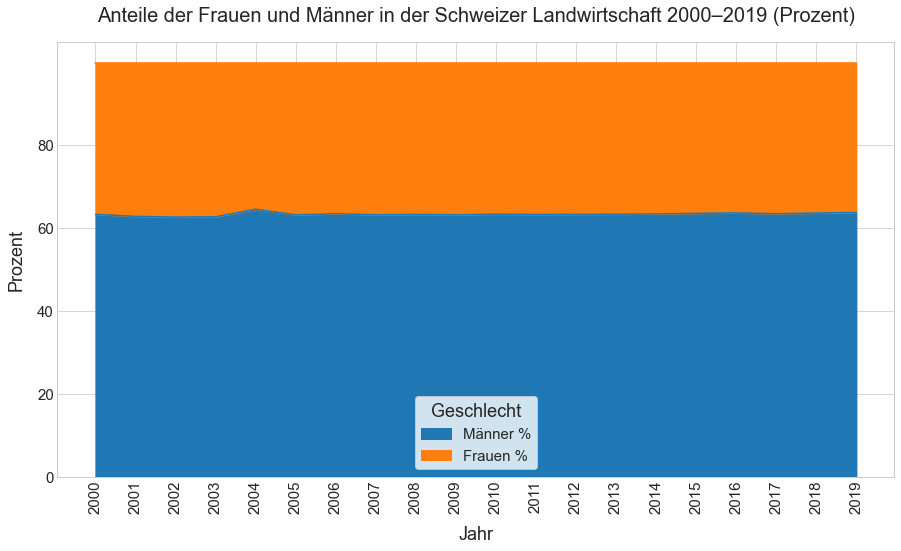

In [31]:
# Plot erstellen
df_ch_gend_pro = df_ch_gend

# Prozentzahlen berechnen
df_ch_gend_pro['Anzahl total'] = df_ch_gend_pro['Männer'] + df_ch_gend_pro['Frauen']
df_ch_gend_pro['Männer %'] = df_ch_gend_pro['Männer'] / df_ch_gend_pro['Anzahl total'] * 100
df_ch_gend_pro['Frauen %'] = df_ch_gend_pro['Frauen'] / df_ch_gend_pro['Anzahl total'] * 100

# Überflüssiges löschen
del df_ch_gend_pro['Männer']
del df_ch_gend_pro['Frauen']
del df_ch_gend_pro['Anzahl total']

# Plot erstellen
df_ch_gend.plot.area(use_index=True, figsize=(15,8), legend=True)
plt.yticks(np.arange(0, 100, step=20))
plt.xticks(np.arange(2000, 2020, step=1))
plt.style.use('seaborn-whitegrid')
plt.title('Anteile der Frauen und Männer in der Schweizer Landwirtschaft 2000–2019 (Prozent)', fontsize=20, pad=20)
plt.xlabel('Jahr', fontsize=18, labelpad=12)
plt.ylabel('Prozent', fontsize=18, labelpad=12)
plt.xticks(fontsize=15, rotation=90)
plt.yticks(fontsize=15)
plt.legend(frameon=True, fontsize=15, title='Geschlecht',title_fontsize=18, loc="lower center")
plt.gca().yaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%d')) 
plt.show()

#### Entwicklung durchschnittliche Betriebsgrösse ab 2000 (df_ch_flaeche_mid)

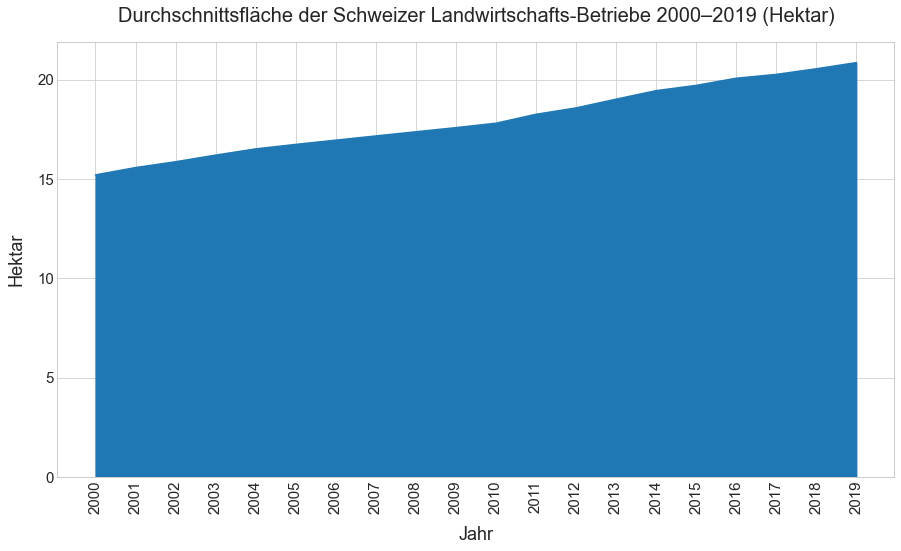

In [32]:
# Landwirtschaftliche Nutzfläche filtern
df_ch_flaeche1 = df_ch.loc[df_ch['Einheit'] == 'LN - Landwirtschaftliche Nutzfläche Total (in ha)', ['Jahr', 'System', 'Anzahl']]

# Betriebe filtern
df_ch_flaeche = df_ch_flaeche1.loc[df_ch_flaeche1['System'] == 'Betriebssystem - Total', ['Jahr', 'Anzahl']]

# Integer auf 'Jahr' anwenden
df_ch_flaeche["Jahr"] = df_ch_flaeche["Jahr"].astype(int)

# Jahre ab und mit 2000 filtern
df_ch_flaeche = df_ch_flaeche[df_ch_flaeche.Jahr >= 2000]

# Integer auf 'Anzahl' anwenden
df_ch_flaeche["Anzahl"] = df_ch_flaeche["Anzahl"].astype(float)

# 'Jahr' als Index setzen
df_ch_flaeche.set_index('Jahr', inplace=True)

# DF für Durchschnitt erstellen
df_ch_flaeche_mid = df_ch_flaeche

# Durchschnitt berechnen
df_ch_flaeche_mid['Anzahl Hektar'] = df_ch_flaeche_mid['Anzahl'] / df_ch_betriebe['Anzahl']

# Überflüssiges löschen
del df_ch_flaeche_mid['Anzahl']

# Plot erstellen
df_ch_flaeche_mid.plot.area(use_index=True, figsize=(15,8), legend=None)
plt.yticks(np.arange(0, 25, step=5))
plt.xticks(np.arange(2000, 2020, step=1))
plt.style.use('seaborn-whitegrid')
plt.title('Durchschnittsfläche der Schweizer Landwirtschafts-Betriebe 2000–2019 (Hektar)', fontsize=20, pad=20)
plt.xlabel('Jahr', fontsize=18, labelpad=12)
plt.ylabel('Hektar', fontsize=18, labelpad=12)
plt.xticks(fontsize=15, rotation=90)
plt.yticks(fontsize=15)
plt.gca().yaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%d')) 
plt.show()

#### Entwicklung LW-Tierbestände in der Schweiz ab 2000 nach Art (df_ch_tier_pivot)

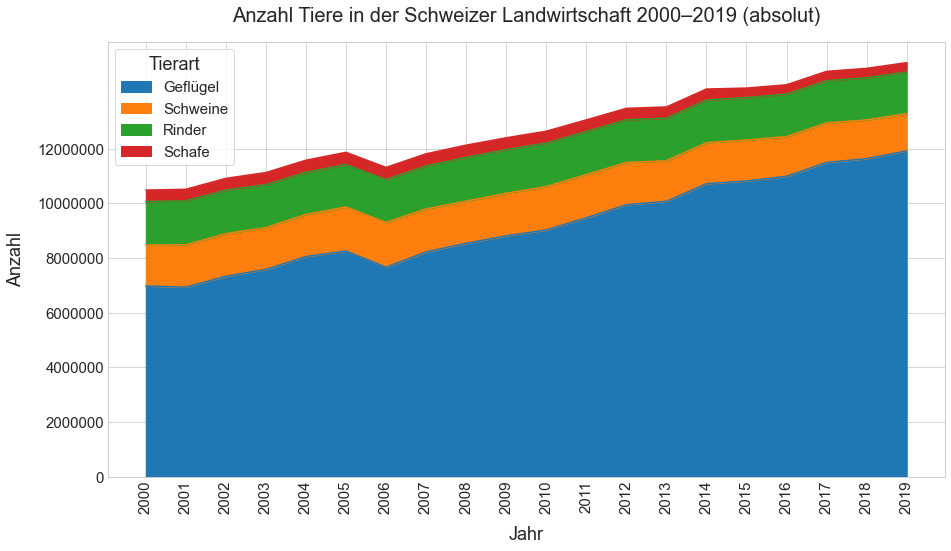

In [33]:
# Integer auf 'Jahr' anwenden
df_ch["Jahr_neu"] = df_ch["Jahr"].astype(int)

# Jahre ab und mit 2000 filtern
df_ch = df_ch[df_ch.Jahr_neu >= 2000]

# Float auf 'Anzahl' anwenden
df_ch["Anzahl"] = df_ch["Anzahl"].astype(float)

# Betriebe filtern
df_ch_tier1 = df_ch.loc[df_ch['System'] == 'Betriebssystem - Total', ['Jahr', 'Einheit', 'Anzahl']]

# DF Tiere erstellen
values=['Tiere - Übrige Tiere', 'Tiere - Geflügel', 'Tiere - Schweine', 'Tiere - Rinder', 'Tiere - Pferdegattung', 'Tiere - Schafe', 'Tiere - Ziege']
df_ch_tier = df_ch_tier1[df_ch_tier1.Einheit.isin(values)]

# In Pivot umwandeln
df_ch_tier_pivot1 = df_ch_tier.pivot(index='Jahr', columns='Einheit', values='Anzahl')

# Spalten umbenennen
df_ch_tier_pivot1 = df_ch_tier_pivot1.rename(columns={'Tiere - Übrige Tiere': 'Übrige Tiere', 'Tiere - Geflügel': 'Geflügel', 'Tiere - Schweine': 'Schweine', 'Tiere - Rinder': 'Rinder', 'Tiere - Pferdegattung': 'Pferdegattung', 'Tiere - Schafe': 'Schafe', 'Tiere - Ziege': 'Ziegen'})

# Spalten neu anordnen
column_order = ['Geflügel', 'Schweine', 'Rinder', 'Schafe']
df_ch_tier_pivot = df_ch_tier_pivot1.reindex(column_order, axis=1)

# Index neu erstellen
df_ch_tier_pivot = df_ch_tier_pivot.reset_index()

# Integer auf 'Jahr' anwenden
df_ch_tier_pivot["Jahr"] = df_ch_tier_pivot["Jahr"].astype(int)

# 'Jahr' als Index setzen
df_ch_tier_pivot.set_index('Jahr', inplace=True)

# Plot erstellen
df_ch_tier_pivot.plot.area(use_index=True, figsize=(15,8))
plt.yticks(np.arange(0, 14000000, step=2000000))
plt.xticks(np.arange(2000, 2020, step=1))
plt.style.use('seaborn-whitegrid')
plt.title('Anzahl Tiere in der Schweizer Landwirtschaft 2000–2019 (absolut)', fontsize=20, pad=20)
plt.xlabel('Jahr', fontsize=18, labelpad=12)
plt.ylabel('Anzahl', fontsize=18, labelpad=12)
plt.xticks(fontsize=15, rotation=90)
plt.yticks(fontsize=15)
plt.legend(frameon=True, fontsize=15, title='Tierart',title_fontsize=18)
plt.gca().yaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%d')) 
plt.show()

### Kantone
#### Entwicklung Anzahl LW Betriebe (Liniendiagramm)

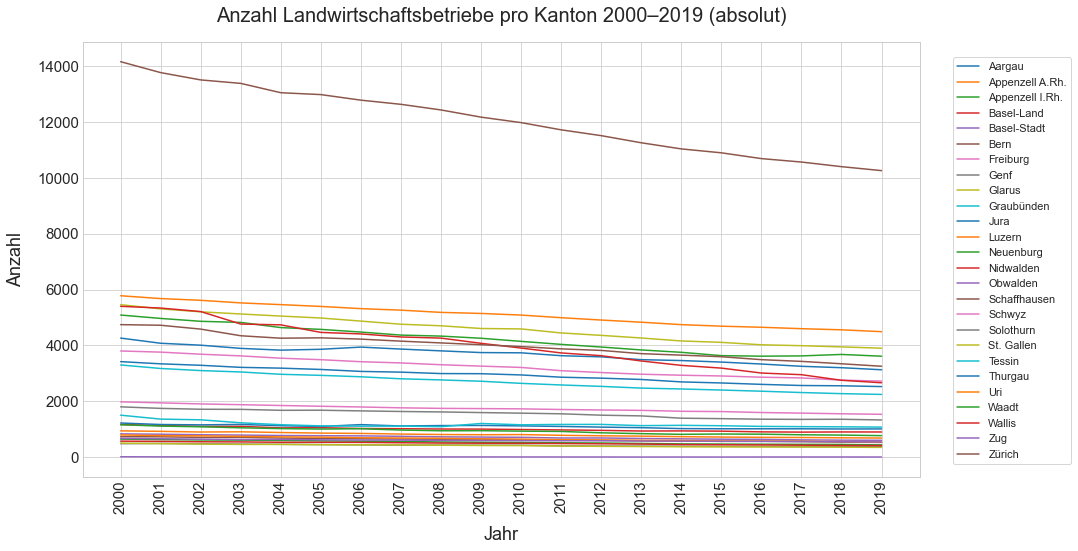

In [34]:
# Betriebe filtern
df_k_betriebe1 = df_k.loc[df_k['Einheit'] == 'Betriebe', ['Jahr', 'Einheit', 'Kanton', 'System', 'Anzahl']]

# 'Betriebssystem - Total' filtern
df_k_betriebe = df_k_betriebe1.loc[df_k_betriebe1['System'] == 'Betriebssystem - Total', ['Jahr', 'Kanton', 'Anzahl']]

# Integer auf 'Jahr' anwenden
df_k_betriebe["Jahr"] = df_k_betriebe["Jahr"].astype(int)

# Jahre ab und mit 2000 filtern
df_k_betriebe = df_k_betriebe[df_k_betriebe.Jahr >= 2000]

# Integer auf 'Anzahl' anwenden
df_k_betriebe["Anzahl"] = df_k_betriebe["Anzahl"].astype(int)

# Index sortieren
df_k_betriebe = df_k_betriebe.sort_index(ascending=True)

# In Pivot umwandeln
df_k_betriebe_pivot1 = df_k_betriebe.pivot(index='Jahr', columns='Kanton', values='Anzahl')

# Plot erstellen
df_k_betriebe_pivot1.plot(use_index=True, figsize=(15,8))
plt.yticks(np.arange(0, 14500, step=2000))
plt.xticks(np.arange(2000, 2020, step=1))
plt.style.use('seaborn-whitegrid')
plt.title('Anzahl Landwirtschaftsbetriebe pro Kanton 2000–2019 (absolut)', fontsize=20, pad=20)
plt.xlabel('Jahr', fontsize=18, labelpad=12)
plt.ylabel('Anzahl', fontsize=18, labelpad=12)
plt.xticks(fontsize=15, rotation=90)
plt.yticks(fontsize=15)
plt.legend(frameon=True, fontsize=11,loc=(1.04,0.03))
plt.gca().yaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%d')) 
plt.show()

#### Entwicklung Anzahl LW-Beschäftigte (Liniendiagramm, df_k_worker_pivot1)

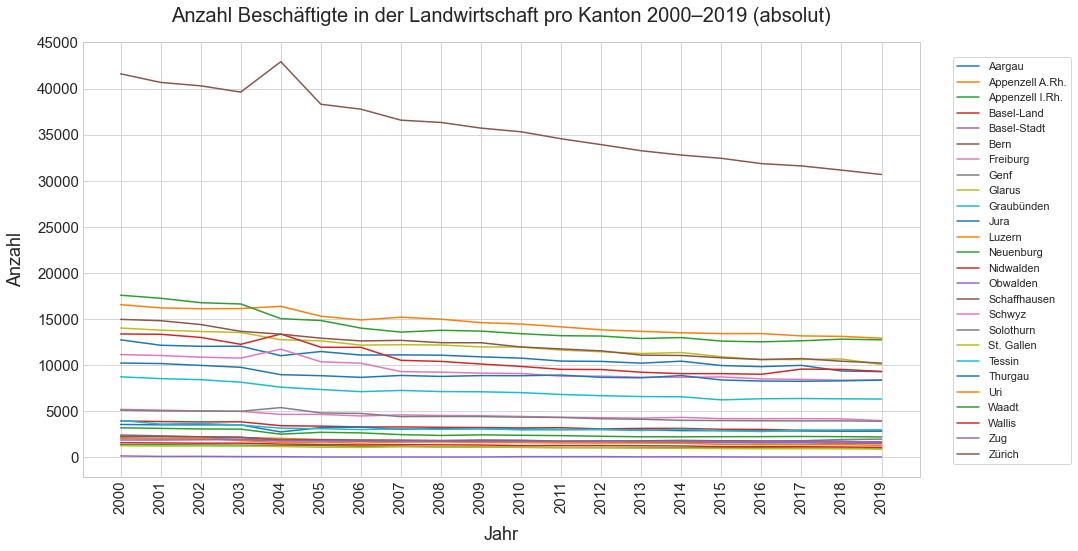

In [35]:
# Beschäftigte filtern
df_k_worker1 = df_k.loc[df_k['Einheit'] == 'Beschäftigte Total', ['Jahr', 'Einheit', 'Kanton', 'System', 'Anzahl']]

# 'Betriebssystem - Total' filtern
df_k_worker = df_k_worker1.loc[df_k_worker1['System'] == 'Betriebssystem - Total', ['Jahr', 'Kanton', 'Anzahl']]

# Integer auf 'Jahr' anwenden
df_k_worker["Jahr"] = df_k_worker["Jahr"].astype(int)

# Jahre ab und mit 2000 filtern
df_k_worker = df_k_worker[df_k_worker.Jahr >= 2000]

# Integer auf 'Anzahl' anwenden
df_k_worker["Anzahl"] = df_k_worker["Anzahl"].astype(int)

# Index neu sortieren
df_k_worker = df_k_worker.sort_index(ascending=True)

# In Pivot umwandeln
df_k_worker_pivot1 = df_k_worker.pivot(index='Jahr', columns='Kanton', values='Anzahl')

# Plot erstellen
df_k_worker_pivot1.plot(use_index=True, figsize=(15,8))
plt.yticks(np.arange(0, 50000, step=5000))
plt.xticks(np.arange(2000, 2020, step=1))
plt.style.use('seaborn-whitegrid')
plt.title('Anzahl Beschäftigte in der Landwirtschaft pro Kanton 2000–2019 (absolut)', fontsize=20, pad=20)
plt.xlabel('Jahr', fontsize=18, labelpad=12)
plt.ylabel('Anzahl', fontsize=18, labelpad=12)
plt.xticks(fontsize=15, rotation=90)
plt.yticks(fontsize=15)
plt.legend(frameon=True, fontsize=11,loc=(1.04,0.03))
plt.gca().yaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%d')) 
plt.show()

#### Durchschnittliche Fläche eines LW-Betrieb (Liniendiagramm, df_k_flaeche_mid_pivot1)

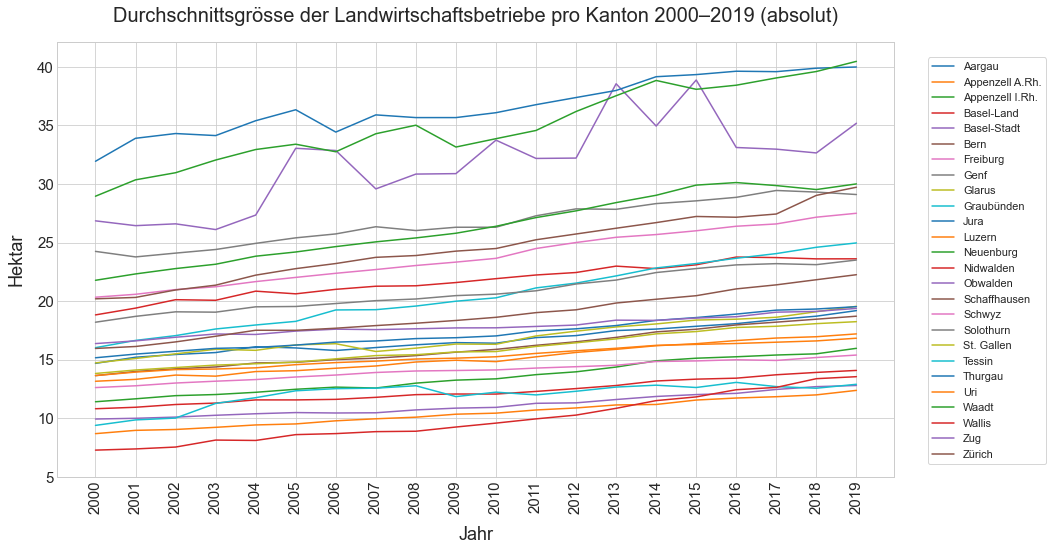

In [36]:
# Landwirtschaftliche Nutzfläche filtern
df_k_flaeche1 = df_k.loc[df_k['Einheit'] == 'LN - Landwirtschaftliche Nutzfläche Total (in ha)', ['Jahr', 'Einheit', 'Kanton', 'System', 'Anzahl']]

# 'Betriebssystem - Total' filtern
df_k_flaeche = df_k_flaeche1.loc[df_k_flaeche1['System'] == 'Betriebssystem - Total', ['Jahr', 'Kanton', 'Anzahl']]

# Integer auf 'Jahr' anwenden
df_k_flaeche["Jahr"] = df_k_flaeche["Jahr"].astype(int)

# Jahre ab und mit 2000 filtern
df_k_flaeche = df_k_flaeche[df_k_flaeche.Jahr >= 2000]

# Float auf 'Anzahl' anwenden
df_k_flaeche["Anzahl"] = df_k_flaeche["Anzahl"].astype(float)

# Jahr und Kanton (Fläche) mergen
df_k_flaeche["fl_Jahr_Kanton"] = df_k_flaeche["Jahr"].astype(str) + [' '] + df_k_flaeche["Kanton"]

# Jahr und Kanton (Betriebe) mergen
df_k_betriebe["be_Jahr_Kanton"] = df_k_betriebe["Jahr"].astype(str) + [' '] + df_k_betriebe["Kanton"]

# Fläche und Betriebe mergen
df_k_flaeche_merg = df_k_flaeche.merge(df_k_betriebe, left_on='fl_Jahr_Kanton', right_on='be_Jahr_Kanton')

# Durchschnitt berechnen
df_k_flaeche_merg['Durchschnitt'] = df_k_flaeche_merg['Anzahl_x'] / df_k_flaeche_merg['Anzahl_y']

# Spalten neu anordnen
df_k_flaeche_mid = df_k_flaeche_merg.reindex(columns=['Jahr_x', 'Kanton_x', 'Durchschnitt'])

# Spalten umbenennen
df_k_flaeche_mid = df_k_flaeche_mid.rename(columns={'Jahr_x': 'Jahr', 'Kanton_x': 'Kanton'})

# Integer auf 'Jahr' anwenden
df_k_flaeche_mid["Jahr"] = df_k_flaeche_mid["Jahr"].astype(int)

# In Pivot umwandeln
df_k_flaeche_mid_pivot1 = df_k_flaeche_mid.pivot(index='Jahr', columns='Kanton', values='Durchschnitt')

# Plot erstellen
df_k_flaeche_mid_pivot1.plot(use_index=True, figsize=(15,8))
plt.yticks(np.arange(5, 45, step=5))
plt.xticks(np.arange(2000, 2020, step=1))
plt.style.use('seaborn-whitegrid')
plt.title('Durchschnittsgrösse der Landwirtschaftsbetriebe pro Kanton 2000–2019 (absolut)', fontsize=20, pad=20)
plt.xlabel('Jahr', fontsize=18, labelpad=12)
plt.ylabel('Hektar', fontsize=18, labelpad=12)
plt.xticks(fontsize=15, rotation=90)
plt.yticks(fontsize=15)
plt.legend(frameon=True, fontsize=11,loc=(1.04,0.03))
plt.gca().yaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%d')) 
plt.show()

#### Anteile der Betriebsarten pro Kanton im Jahr 2019 (Säulendiagramm, df_k_art_pivot)

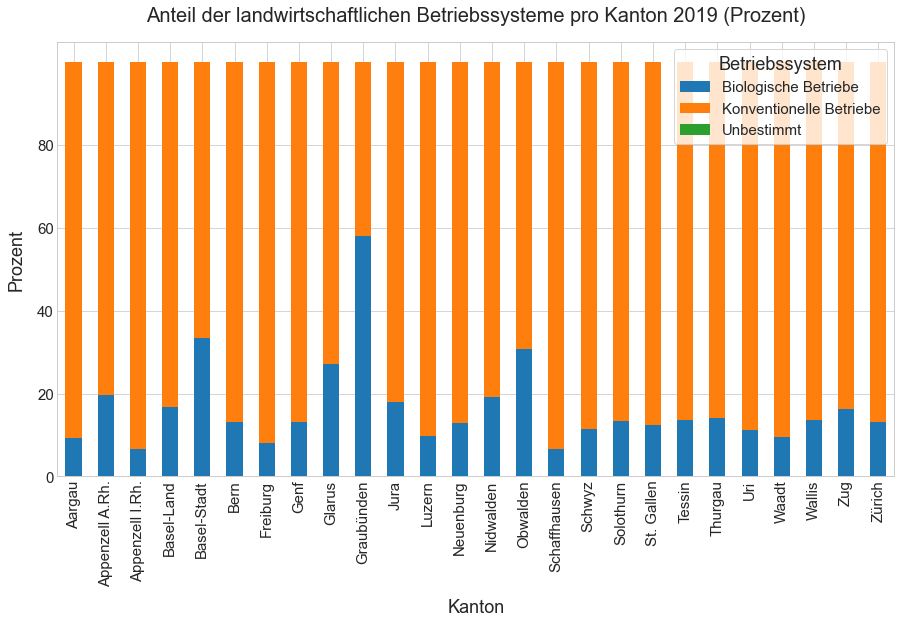

In [37]:
# Jahr 2019 filtern
df_k_art1 = df_k.loc[df_k['Jahr'] == '2019', ['Jahr', 'Einheit', 'Kanton', 'System', 'Anzahl']]

# Betriebe filtern
df_k_art1 = df_k_art1.loc[df_k_art1['Einheit'] == 'Betriebe', ['Kanton', 'System', 'Anzahl']]

# 'Betriebssystem total' entfernen
df_k_art = df_k_art1.loc[df_k_art1['System'] != 'Betriebssystem - Total', ['Kanton', 'System', 'Anzahl']]

# Float auf Anzahl anwenden
df_k_art['Anzahl'] = df_k_art['Anzahl'].astype(float)

# In Pivot umwandeln
df_k_art_pivot1 = df_k_art.pivot(index='Kanton', columns='System', values='Anzahl')

# Anteile berechnen
df_k_art_pivot1['Bio_Prozent'] = df_k_art_pivot1['Biologische Betriebe'] * 100 / (df_k_art_pivot1['Biologische Betriebe'] + df_k_art_pivot1['Konventionelle Betriebe'] + df_k_art_pivot1['Unbestimmt']) 
df_k_art_pivot1['Konv_Prozent'] = df_k_art_pivot1['Konventionelle Betriebe'] * 100 / (df_k_art_pivot1['Biologische Betriebe'] + df_k_art_pivot1['Konventionelle Betriebe'] + df_k_art_pivot1['Unbestimmt'])
df_k_art_pivot1['Unb_Prozent'] = df_k_art_pivot1['Unbestimmt'] * 100 / (df_k_art_pivot1['Biologische Betriebe'] + df_k_art_pivot1['Konventionelle Betriebe'] + df_k_art_pivot1['Unbestimmt'])

# Überflüssiges löschen
del df_k_art_pivot1['Biologische Betriebe']
del df_k_art_pivot1['Konventionelle Betriebe']
del df_k_art_pivot1['Unbestimmt']

# Float auf Prozente anwenden
df_k_art_pivot1['Bio_Prozent'] = df_k_art_pivot1['Bio_Prozent'].astype(float)
df_k_art_pivot1['Konv_Prozent'] = df_k_art_pivot1['Konv_Prozent'].astype(float)
df_k_art_pivot1['Unb_Prozent'] = df_k_art_pivot1['Unb_Prozent'].astype(float)

# Spalten umbenennen
df_k_art_pivot = df_k_art_pivot1.rename(columns={'Bio_Prozent': 'Biologische Betriebe', 'Konv_Prozent': 'Konventionelle Betriebe', 'Unb_Prozent': 'Unbestimmt'})

# Plot erstellen
df_k_art_pivot.plot(kind='bar', stacked=True, use_index=True, figsize=(15,8), legend=True)
plt.yticks(np.arange(0, 100, step=20))
plt.style.use('seaborn-whitegrid')
plt.title('Anteil der landwirtschaftlichen Betriebssysteme pro Kanton 2019 (Prozent)', fontsize=20, pad=20)
plt.xlabel('Kanton', fontsize=18, labelpad=12)
plt.ylabel('Prozent', fontsize=18, labelpad=12)
plt.xticks(fontsize=15, rotation=90)
plt.yticks(fontsize=15)
plt.legend(frameon=True, fontsize=15, title='Betriebssystem',title_fontsize=18, loc="upper right")
plt.gca().yaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%d')) 
plt.show()

#### Anteil der biologischen LW-Betriebe pro Kanton 2019 in Prozent (Karte, gdf_kantone_bio)

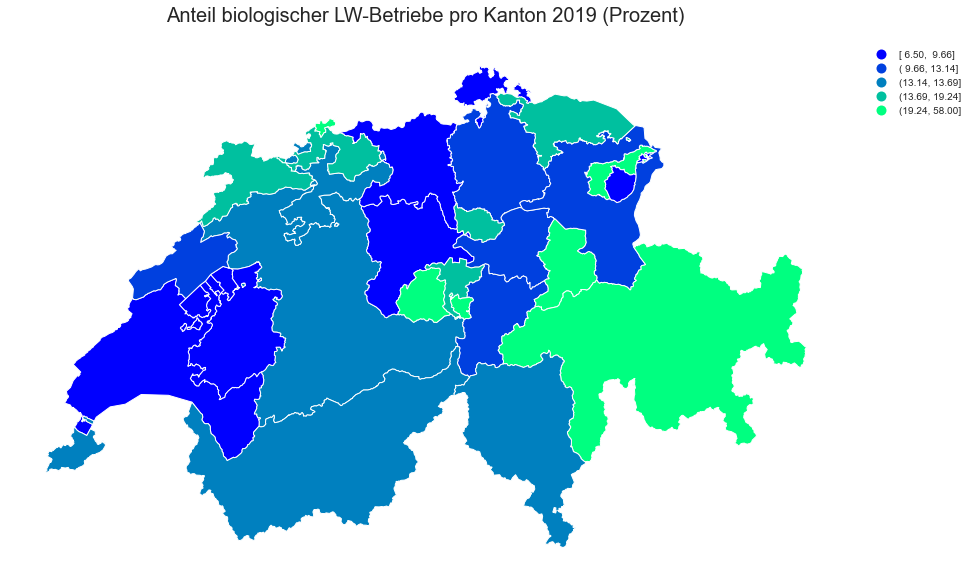

In [38]:
# Dataframe für Bio-Anteil erstellen
df_k_bio = df_k_art_pivot

# Unnötiges löschen
del df_k_art_pivot['Konventionelle Betriebe']
del df_k_art_pivot['Unbestimmt']

# Bio-Anteil mit Geometrie mergen
gdf_kantone_bio = gdf_kantone.merge(df_k_bio, how='inner', left_on='KTNAME', right_index=True)

# Karte plotten
ax = gdf_kantone_bio.plot(column='Biologische Betriebe', cmap='winter', scheme='quantiles', edgecolor='white', legend=True, figsize=(15,10))
ax.set_title('Anteil biologischer LW-Betriebe pro Kanton 2019 (Prozent)', fontsize=20, pad=20)
leg = ax.get_legend()
leg.set_bbox_to_anchor((1.15,1))
ax.set_axis_off()

#### Anzahl des Geflügels je Kanton 2019 in 100'000 (Säulendiagramm, df_k_huhn_pivot)

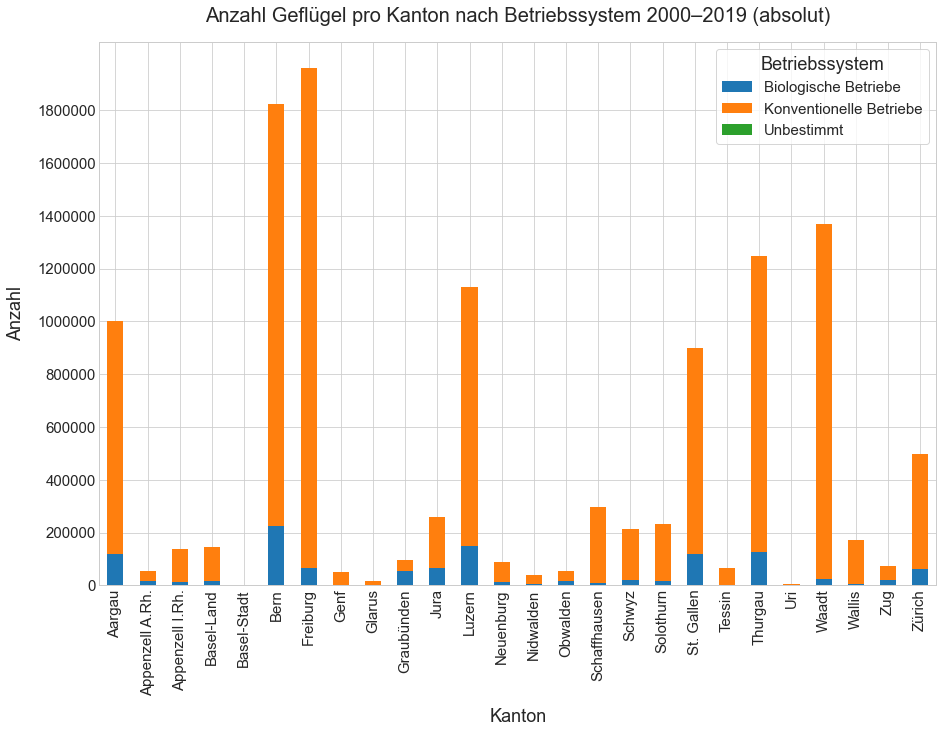

In [39]:
# Jahr 2019 filtern
df_k_huhn1 = df_k.loc[df_k['Jahr'] == '2019', ['Jahr', 'Einheit', 'Kanton', 'System', 'Anzahl']]

# 'Betriebssystem total' entfernen
df_k_huhn1 = df_k_huhn1.loc[df_k_huhn1['System'] != 'Betriebssystem - Total', ['Kanton', 'System', 'Einheit', 'Anzahl']]

# 'Tiere - Geflügel' filtern
df_k_huhn = df_k_huhn1.loc[df_k_huhn1['Einheit'] == 'Tiere - Geflügel', ['Kanton', 'System', 'Anzahl']]

# Float auf Anzahl anwenden
df_k_huhn['Anzahl'] = df_k_huhn['Anzahl'].astype(float)

# In Pivot umwandeln
df_k_huhn_pivot = df_k_huhn.pivot(index='Kanton', columns='System', values='Anzahl')

# Plot erstellen
df_k_huhn_pivot.plot(kind='bar', stacked=True, use_index=True, figsize=(15,10), legend=True)
plt.yticks(np.arange(0, 2000000, step=200000))
plt.style.use('seaborn-whitegrid')
plt.title('Anzahl Geflügel pro Kanton nach Betriebssystem 2000–2019 (absolut)', fontsize=20, pad=20)
plt.xlabel('Kanton', fontsize=18, labelpad=12)
plt.ylabel('Anzahl', fontsize=18, labelpad=12)
plt.xticks(fontsize=15, rotation=90)
plt.yticks(fontsize=15)
plt.legend(frameon=True, fontsize=15, title='Betriebssystem',title_fontsize=18, loc="upper right")
plt.gca().yaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%d')) 
plt.show()

#### Anteil Bio-Geflügel pro Kanton 2019 in Prozent (Karte, gdf_kantone_bio)

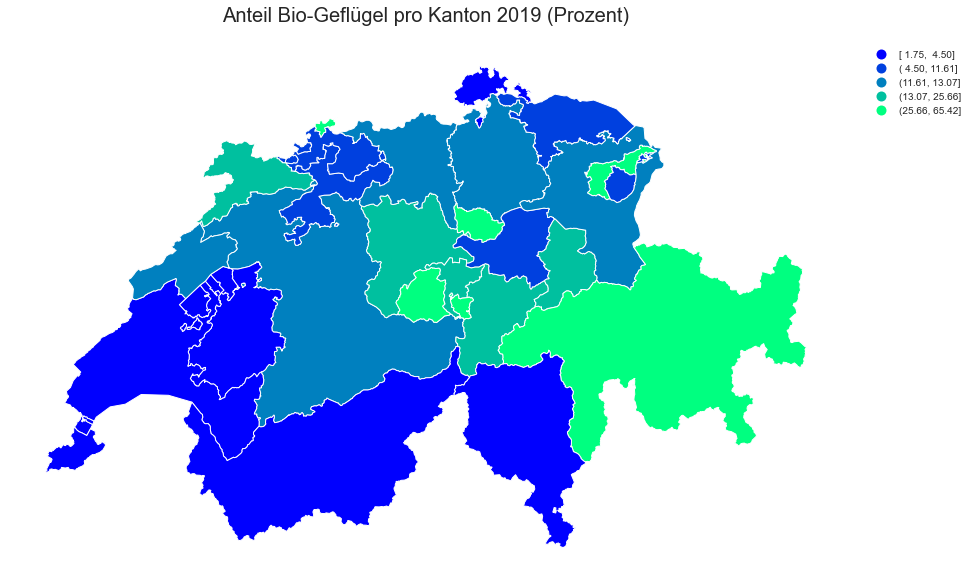

In [40]:
# DF Bio-Hühner erstellen
df_k_biohuhn = df_k_huhn_pivot

# Prozente berechnen
df_k_biohuhn['Bio_Prozent'] = df_k_biohuhn['Biologische Betriebe'] * 100 / (df_k_biohuhn['Biologische Betriebe'] + df_k_biohuhn['Konventionelle Betriebe'] + df_k_biohuhn['Unbestimmt']) 

# Unnötiges löschen
del df_k_biohuhn['Unbestimmt']

# Bio-Hühner mit Geometrie mergen
gdf_kantone_bio = gdf_kantone.merge(df_k_biohuhn, how='inner', left_on='KTNAME', right_index=True)

# Karte plotten
ax = gdf_kantone_bio.plot(column='Bio_Prozent', cmap='winter', scheme='quantiles', edgecolor='white', legend=True, figsize=(15,10))
ax.set_title('Anteil Bio-Geflügel pro Kanton 2019 (Prozent)', fontsize=20, pad=20)
leg = ax.get_legend()
leg.set_bbox_to_anchor((1.15,1))
ax.set_axis_off()

### Schaffhausen
#### Rückgang der LW-Betriebe 2000–2019 in Prozent (Karte, gdf_sh_betriebe20y)

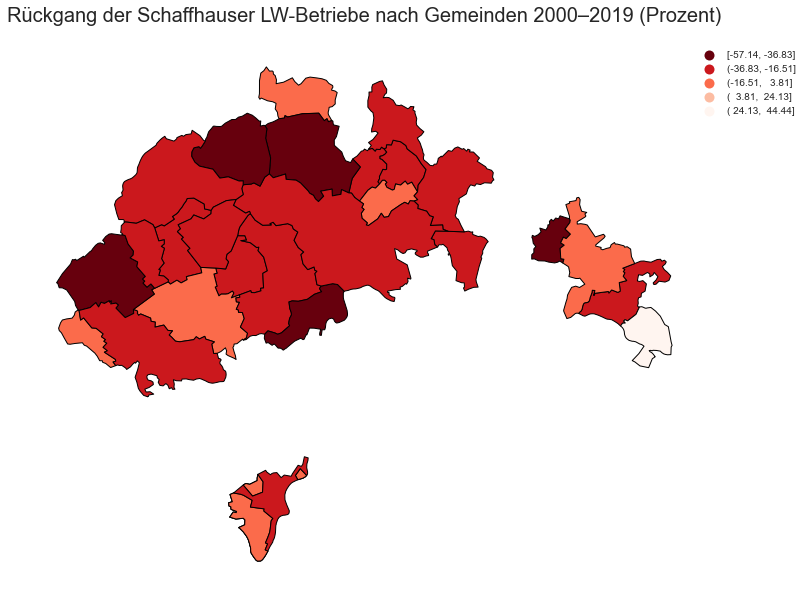

In [41]:
# Betriebe filtern
gdf_sh_betriebe1 = gdf_sh.loc[gdf_sh['Einheit'] == 'Betriebe', ['Gemeinde', 'Gemeindenummer', 'Einheit', 'System', 'Anzahl', 'geometry']]

# 'Betriebssystem - Total' filtern
gdf_sh_betriebe1 = gdf_sh_betriebe1.loc[gdf_sh_betriebe1['System'] == 'Betriebssystem - Total', ['Gemeinde', 'Gemeindenummer', 'Einheit', 'System', 'Anzahl', 'geometry']]

# DF fürs Jahr 2019 erstellen
gdf_sh_betriebe2019 = gdf_sh_betriebe1.loc[gdf_sh['Jahr'] == '2019', ['Gemeinde', 'Gemeindenummer', 'Einheit', 'System', 'Anzahl', 'geometry']]

# DF fürs Jahr 2000 erstellen
gdf_sh_betriebe2000 = gdf_sh_betriebe1.loc[gdf_sh['Jahr'] == '2000', ['Gemeinde', 'Gemeindenummer', 'Einheit', 'System', 'Anzahl']]

# Integer auf 'Anzahl' anwenden
gdf_sh_betriebe2019['Anzahl'] = gdf_sh_betriebe2019['Anzahl'].astype(int)
gdf_sh_betriebe2000['Anzahl'] = gdf_sh_betriebe2000['Anzahl'].astype(int)

# In ein DF mergen
gdf_sh_betriebe2000_2019 = gdf_sh_betriebe2019.merge(gdf_sh_betriebe2000, left_on='Gemeindenummer', right_on='Gemeindenummer')

# Unnötiges löschen
del gdf_sh_betriebe2000_2019['Gemeinde_y']
del gdf_sh_betriebe2000_2019['Gemeindenummer']
del gdf_sh_betriebe2000_2019['Einheit_y']
del gdf_sh_betriebe2000_2019['System_y']

# Spalten umbenennen
gdf_sh_betriebe2000_2019 = gdf_sh_betriebe2000_2019.rename(columns={'Gemeinde_x': 'Gemeinde', 'Einheit_x': 'Einheit', 'System_x': 'System', 'Anzahl_y': 'Anzahl2000', 'Anzahl_x': 'Anzahl2019'})

# Prozente berechnen
gdf_sh_betriebe2000_2019['Prozente'] = gdf_sh_betriebe2000_2019['Anzahl2019'] / gdf_sh_betriebe2000_2019['Anzahl2000'] * 100 - 100

# Unnötiges löschen
del gdf_sh_betriebe2000_2019['Anzahl2000']
del gdf_sh_betriebe2000_2019['Anzahl2019']
del gdf_sh_betriebe2000_2019['System']
del gdf_sh_betriebe2000_2019['Einheit']

# Wieder in GDF umwandeln
gdf_sh_betriebe20y = GeoDataFrame(gdf_sh_betriebe2000_2019)

# Karte plotten
ax = gdf_sh_betriebe20y.plot(column='Prozente', cmap='Reds_r', scheme='equalinterval', edgecolor='black', legend=True, figsize=(15,10))
ax.set_title('Rückgang der Schaffhauser LW-Betriebe nach Gemeinden 2000–2019 (Prozent)', fontsize=20, pad=20)
leg = ax.get_legend()
leg.set_bbox_to_anchor((1.15,1))
ax.set_axis_off()

#### Rückgang der Beschäftigtenzahl in der Schaffhauser Landwirtschaft 2000–2019 in Prozent (Karte, gdf_sh_worker20y) 

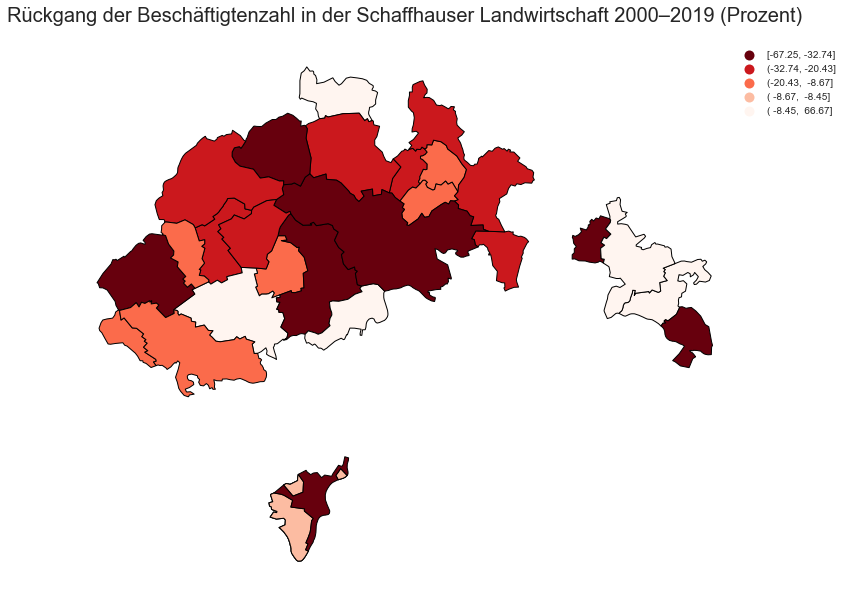

In [42]:
# Beschäftigte filtern
gdf_sh_worker1 = gdf_sh.loc[gdf_sh['Einheit'] == 'Beschäftigte Total', ['Jahr', 'Gemeinde', 'Gemeindenummer', 'Einheit', 'System', 'Anzahl', 'geometry']]

# Betriebssystem - Total' filtern
gdf_sh_worker1 = gdf_sh_worker1.loc[gdf_sh_worker1['System'] == 'Betriebssystem - Total', ['Jahr', 'Gemeinde', 'Gemeindenummer', 'Einheit', 'System', 'Anzahl', 'geometry']]
gdf_sh_worker2 = gdf_sh_worker1.loc[gdf_sh_worker1['System'] == 'Betriebssystem - Total', ['Jahr', 'Gemeinde', 'Gemeindenummer', 'Einheit', 'System', 'Anzahl', 'geometry']]

# GDF fürs Jahr 2019 erstellen
gdf_sh_worker2019 = gdf_sh_worker1.loc[gdf_sh_worker1['Jahr'] == '2019', ['Gemeinde', 'Gemeindenummer', 'Einheit', 'System', 'Anzahl', 'geometry']]

# GDF fürs Jahr 2019 erstellen
gdf_sh_worker2000 = gdf_sh_worker2.loc[gdf_sh_worker2['Jahr'] == '2000', ['Gemeinde', 'Gemeindenummer', 'Einheit', 'System', 'Anzahl']]

# Integer auf 'Anzahl' anwenden
gdf_sh_worker2019['Anzahl'] = gdf_sh_worker2019['Anzahl'].astype(int)
gdf_sh_worker2000['Anzahl'] = gdf_sh_worker2000['Anzahl'].astype(int)

# In ein GDF mergen
gdf_sh_worker2000_2019 = gdf_sh_worker2019.merge(gdf_sh_worker2000, left_on='Gemeindenummer', right_on='Gemeindenummer')

# Unnötiges löschen
del gdf_sh_worker2000_2019['Gemeinde_y']
del gdf_sh_worker2000_2019['Gemeindenummer']
del gdf_sh_worker2000_2019['Einheit_y']
del gdf_sh_worker2000_2019['System_y']

# Spalten umbenennen
gdf_sh_worker2000_2019 = gdf_sh_worker2000_2019.rename(columns={'Gemeinde_x': 'Gemeinde', 'Einheit_x': 'Einheit', 'System_x': 'System', 'Anzahl_y': 'Anzahl2000', 'Anzahl_x': 'Anzahl2019'})

# Prozente berechnen
gdf_sh_worker2000_2019['Prozente'] = gdf_sh_worker2000_2019['Anzahl2019'] / gdf_sh_worker2000_2019['Anzahl2000'] * 100 - 100

# Unnötiges löschen
del gdf_sh_worker2000_2019['Anzahl2000']
del gdf_sh_worker2000_2019['Anzahl2019']
del gdf_sh_worker2000_2019['System']
del gdf_sh_worker2000_2019['Einheit']

# Wieder in GDF umwandeln
gdf_sh_worker20y = GeoDataFrame(gdf_sh_worker2000_2019)

# Karte plotten
ax = gdf_sh_worker20y.plot(column='Prozente', cmap='Reds_r', scheme='quantiles', edgecolor='black', legend=True, figsize=(15,10))
ax.set_title('Rückgang der Beschäftigtenzahl in der Schaffhauser Landwirtschaft 2000–2019 (Prozent)', fontsize=20, pad=20)
leg = ax.get_legend()
leg.set_bbox_to_anchor((1.15,1))
ax.set_axis_off()

#### Anzahl der Beschäftigten in der Schaffhauser Landwirtschaft nach Gemeinden 2000–2019 (Scatterplott, df_sh_worker_unique) 

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


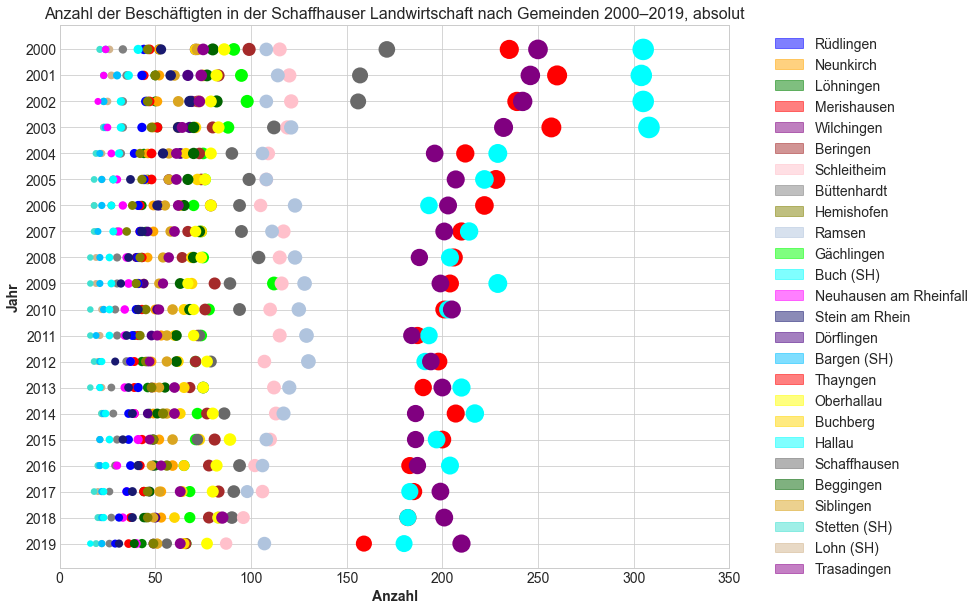

In [43]:
# Betriebe filtern
df_sh_worker = gdf_sh_worker1.loc[gdf_sh_worker1['System'] == 'Betriebssystem - Total', ['Gemeinde', 'Jahr', 'Anzahl',]]

# Integer auf 'Jahr' anwenden
df_sh_worker["Jahr"] = df_sh_worker["Jahr"].astype(int)

# Jahre ab und mit 2000 filtern
df_sh_worker = df_sh_worker[df_sh_worker.Jahr >= 2000]

# Integer auf 'Anzahl' anwenden
df_sh_worker["Anzahl"] = df_sh_worker["Anzahl"].astype(int)

# String auf 'Jahr' anwenden
df_sh_worker["Jahr"] = df_sh_worker["Jahr"].astype(str)

# Index sortieren
df_sh_worker = df_sh_worker.sort_index(ascending=True)

# String auf 'Jahr' anwenden
df_sh_worker["Jahr"] = df_sh_worker["Jahr"].astype(str)

# Duplikate entfernen
df_sh_worker_unique = df_sh_worker.drop_duplicates()

# Farben bestimmen
colors = {
    'Rüdlingen': 'blue',
    'Neunkirch': 'orange',
    'Löhningen': 'green',
    'Merishausen': 'red',
    'Wilchingen': 'purple',
    'Beringen': 'brown',
    'Schleitheim': 'pink',
    'Büttenhardt': 'grey',
    'Hemishofen': 'olive',
    'Ramsen': 'lightsteelblue',
    'Gächlingen': 'lime',
    'Buch (SH)': 'aqua',
    'Neuhausen am Rheinfall': 'fuchsia',
    'Stein am Rhein': 'midnightblue',
    'Dörflingen': 'indigo',
    'Bargen (SH)': 'deepskyblue',
    'Thayngen': 'red',
    'Oberhallau': 'yellow',
    'Buchberg': 'gold',
    'Hallau': 'cyan',
    'Schaffhausen': 'dimgrey',
    'Beggingen': 'darkgreen',
    'Siblingen': 'goldenrod',
    'Stetten (SH)': 'turquoise',
    'Lohn (SH)': 'tan',
    'Trasadingen': 'darkmagenta'
}

# Farbliste erstellen
colorlist = df_sh_worker_unique['Gemeinde'].apply(lambda Gemeinde: colors[Gemeinde])

# Punktgrössen bestimmen
area = df_sh_worker_unique['Anzahl'] *10 / 8

# Patches erstellen
patches = []
for Gemeinde, color in colors.items():
    this_patch = mpatches.Patch(color=color, label=Gemeinde, alpha=0.5)
    patches.append(this_patch)
    
# Plot erstellen
ax = df_sh_worker_unique.plot(kind='scatter', 
        x='Anzahl', 
        y='Jahr', 
        s=area,
        color=colorlist,
        linewidth=2, 
        xlim=(0, 350),
        figsize=(12,10),
        grid=True,
        fontsize=14)

# Titel setzen
ax.set_title('Anzahl der Beschäftigten in der Schaffhauser Landwirtschaft nach Gemeinden 2000–2019, absolut', fontsize=16)

# Achsen beschriften
ax.set_ylabel("Jahr", fontsize=14, fontweight='bold')
ax.set_xlabel("Anzahl", fontsize=14, fontweight='bold')

# Legende erstellen
ax.legend(handles=patches, frameon=False, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=14)

#### 8 Schaffhauser Gemeinden mit dem grössten Rückgang der LW-Beschäftigten (df_sh_worker_extrem_diff_pivot)

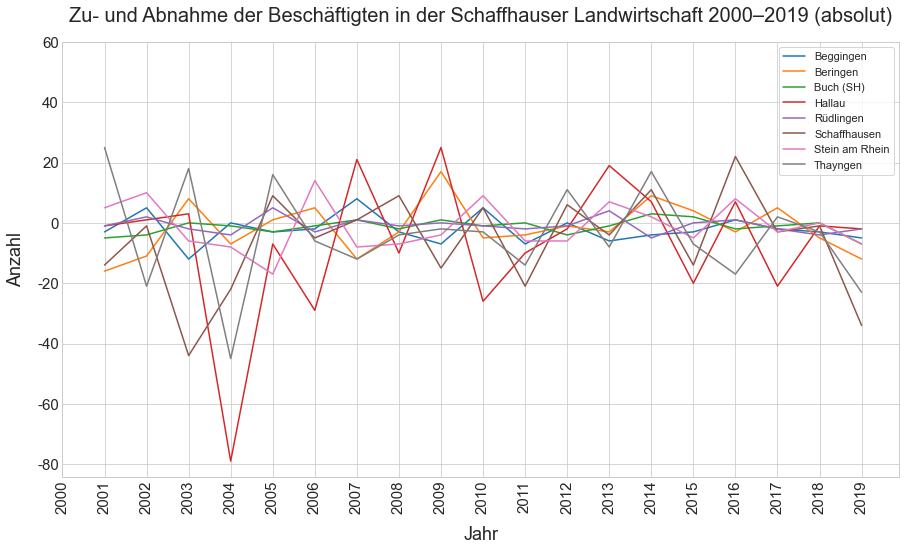

In [44]:
# 'Hallau' filtern
Hallau = df_sh_worker_unique.loc[df_sh_worker_unique['Gemeinde'] == 'Hallau', ['Gemeinde', 'Jahr', 'Anzahl',]]

# 'Jahr' als Index setzen
Hallau = Hallau.set_index('Jahr')

# Index sortieren
Hallau = Hallau.sort_index(ascending=True)

# Neue Spalte 'Differenz' erstellen
Hallau["Differenz"] = Hallau["Anzahl"].diff()


# 'Beggingen' wie 'Hallau'
Beggingen = df_sh_worker_unique.loc[df_sh_worker_unique['Gemeinde'] == 'Beggingen', ['Gemeinde', 'Jahr', 'Anzahl',]]
Beggingen = Beggingen.set_index('Jahr')
Beggingen = Beggingen.sort_index(ascending=True)
Beggingen["Differenz"] = Beggingen["Anzahl"].diff()

# 'Schaffhausen' wie 'Hallau'
Schaffhausen = df_sh_worker_unique.loc[df_sh_worker_unique['Gemeinde'] == 'Schaffhausen', ['Gemeinde', 'Jahr', 'Anzahl',]]
Schaffhausen = Schaffhausen.set_index('Jahr')
Schaffhausen = Schaffhausen.sort_index(ascending=True)
Schaffhausen["Differenz"] = Schaffhausen["Anzahl"].diff()

# 'Beringen' wie 'Hallau'
Beringen = df_sh_worker_unique.loc[df_sh_worker_unique['Gemeinde'] == 'Beringen', ['Gemeinde', 'Jahr', 'Anzahl',]]
Beringen = Beringen.set_index('Jahr')
Beringen = Beringen.sort_index(ascending=True)
Beringen["Differenz"] = Beringen["Anzahl"].diff()

# 'Rüdlingen' wie 'Hallau'
Ruedlingen = df_sh_worker_unique.loc[df_sh_worker_unique['Gemeinde'] == 'Rüdlingen', ['Gemeinde', 'Jahr', 'Anzahl',]]
Ruedlingen = Ruedlingen.set_index('Jahr')
Ruedlingen = Ruedlingen.sort_index(ascending=True)
Ruedlingen["Differenz"] = Ruedlingen["Anzahl"].diff()

# 'Buch SH' wie 'Hallau'
Buch = df_sh_worker_unique.loc[df_sh_worker_unique['Gemeinde'] == 'Buch (SH)', ['Gemeinde', 'Jahr', 'Anzahl',]]
Buch = Buch.set_index('Jahr')
Buch = Buch.sort_index(ascending=True)
Buch["Differenz"] = Buch["Anzahl"].diff()

# 'Stein am Rhein' wie 'Hallau'
Stein = df_sh_worker_unique.loc[df_sh_worker_unique['Gemeinde'] == 'Stein am Rhein', ['Gemeinde', 'Jahr', 'Anzahl',]]
Stein = Stein.set_index('Jahr')
Stein = Stein.sort_index(ascending=True)
Stein["Differenz"] = Stein["Anzahl"].diff()

# 'Thayngen' wie 'Hallau'
Thayngen = df_sh_worker_unique.loc[df_sh_worker_unique['Gemeinde'] == 'Thayngen', ['Gemeinde', 'Jahr', 'Anzahl',]]
Thayngen = Thayngen.set_index('Jahr')
Thayngen = Thayngen.sort_index(ascending=True)
Thayngen["Differenz"] = Thayngen["Anzahl"].diff()

# In ein DF appenden
df_sh_worker_extrem = Hallau.append([Beggingen, Schaffhausen, Beringen, Ruedlingen, Buch, Stein, Thayngen])

# Index neu erstellen
df_sh_worker_extrem = df_sh_worker_extrem.reset_index()

# Jahr 2000 entfernen (keine Differenz enthalten)
df_sh_worker_extrem_diff = df_sh_worker_extrem.loc[df_sh_worker_extrem['Jahr'] != '2000', ['Gemeinde', 'Jahr', 'Differenz']]

# Integer auf 'Jahr' anwenden
df_sh_worker_extrem_diff["Jahr"] = df_sh_worker_extrem_diff["Jahr"].astype(int)

# In Pivot umwandeln
df_sh_worker_extrem_diff_pivot = df_sh_worker_extrem_diff.pivot(index='Jahr', columns='Gemeinde', values='Differenz')

# Index neu erstellen
df_sh_worker_extrem_diff_pivot = df_sh_worker_extrem_diff_pivot.reset_index()

# Integer auf 'Jahr' anwenden
df_sh_worker_extrem_diff_pivot["Jahr"] = df_sh_worker_extrem_diff_pivot["Jahr"].astype(int)

# 'Jahr' als Index setzen
df_sh_worker_extrem_diff_pivot.set_index('Jahr', inplace=True)

# Integer auf 'Differenz' anwenden
df_sh_worker_extrem_diff["Differenz"] = df_sh_worker_extrem_diff["Differenz"].astype(float)

# Plot erstellen
df_sh_worker_extrem_diff_pivot.plot(use_index=True, figsize=(15,8))
plt.yticks(np.arange(-80, 80, step=20))
plt.xticks(np.arange(2000, 2020, step=1))
plt.style.use('seaborn-whitegrid')
plt.title('Zu- und Abnahme der Beschäftigten in der Schaffhauser Landwirtschaft 2000–2019 (absolut)', fontsize=20, pad=20)
plt.xlabel('Jahr', fontsize=18, labelpad=12)
plt.ylabel('Anzahl', fontsize=18, labelpad=12)
plt.xticks(fontsize=15, rotation=90)
plt.yticks(fontsize=15)
plt.legend(frameon=True, fontsize=11)
plt.gca().yaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%d')) 
plt.show()

#### Zu- und Abnahme der Beschäftigten in der Schaffhauser Landwirtschaft (df_sh_worker_extrem_diff_pivot)

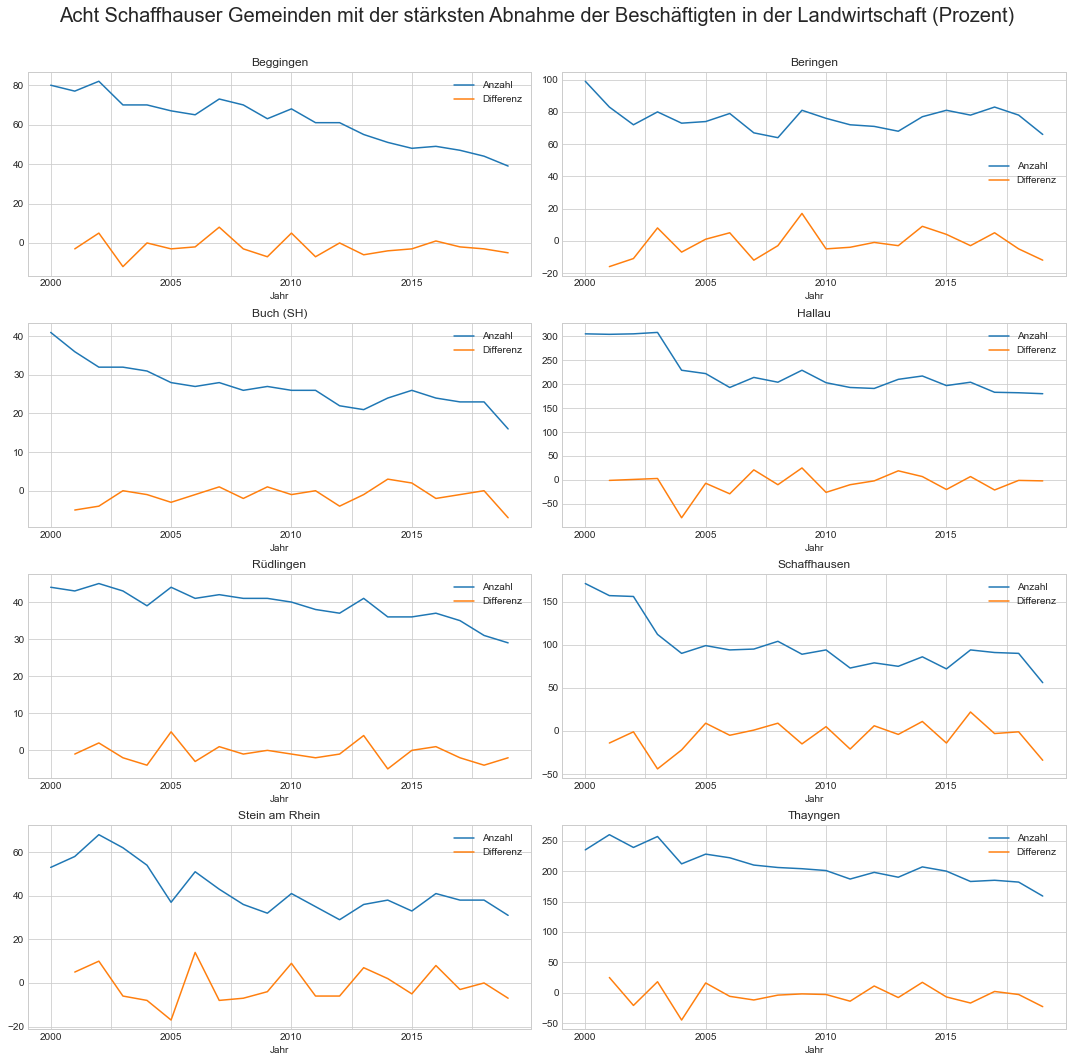

In [45]:
# Subplot für extremste Gemeinden erstellen
fig, axes = plt.subplots(figsize=(15,15), nrows=4, ncols=2)

# Plots der einzelnen Gemeinden
Beggingen.plot(ax=axes[0,0], title='Beggingen')
Beringen.plot(ax=axes[0,1], title='Beringen')
Buch.plot(ax=axes[1,0], title='Buch (SH)')
Hallau.plot(ax=axes[1,1], title='Hallau')
Ruedlingen.plot(ax=axes[2,0], title='Rüdlingen')
Schaffhausen.plot(ax=axes[2,1], title='Schaffhausen')
Stein.plot(ax=axes[3,0], title='Stein am Rhein')
Thayngen.plot(ax=axes[3,1], title='Thayngen')

# Subplot gestalten
fig.tight_layout()
fig.subplots_adjust(top=0.92)
fig.suptitle('Acht Schaffhauser Gemeinden mit der stärksten Abnahme der Beschäftigten in der Landwirtschaft (Prozent)', size=20)

# Subplot erstellen
plt.show()